<center><b>ASSIGNMENT 2 — Phys 512 — Julia Lascar</b></center>
<b>1. a)</b> Write a function that models the log base 2 of x valid from 0.5 to 1 to an accuracy in the region better than 10−6. Please use a truncated Chebyshev polynomial fit to do this, and please write your own fit routine (instead of just calling the numpy one). 

4.9157832978335375e-06


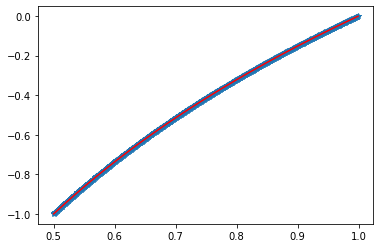

In [208]:
import numpy as np
from matplotlib import pyplot as plt
    
def Chebyshev(x,y,n): 
    A=np.zeros([len(x),n])
    A[:,0]=1.0
    for i in range(1,n):
        A[:,i]=x*A[:,i-1]
    T=np.zeros([len(x),n]) 
    T[:,0]=1 
    T[:,1]=x
    for i in range(2,n):
        T[:,i]=2*x*T[:,i-1]-T[:,i-2]
    A=np.matrix(A) 
    d=np.matrix(y).transpose()
    lhs=A.transpose()*A
    rhs=A.transpose()*d
    fitp=np.linalg.inv(lhs)*rhs
    pred=A*fitp
    pred1=np.squeeze(np.asarray(pred))
    return pred1

x=np.arange(0.5,1,0.001)
y=np.log2(x)
n=7 #We need 7 terms
pred=Chebyshev(x,y,n)
error=np.mean(np.abs(pred-y))
print(error)
plt.clf();plt.plot(x,y,'*');plt.plot(x,pred,'r');

plt.show()

Carry out a least squares polynomial fit of the same order, 
and overplot the residuals. How do the max errors compare? 
How about the RMS? Feel free to use a built-in routine for the second fit.

rms error for least-squares is  9.986753267495442e-05  with max error  0.0002564113105946045
rms error for chebyshev     is  5.127584893934344e-06  with max error  7.4887160916858875e-06


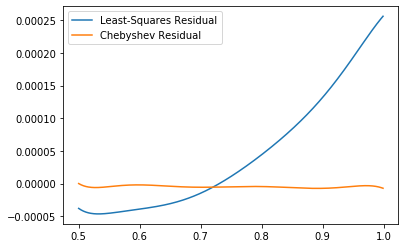

In [209]:
def leastsquare(x,y,ord): 
    A=np.zeros([len(x),ord])
    A[:,0]=1.0
    for i in range(1,ord):
        A[:,i]=x*A[:,i-1]
    T=np.zeros([len(x),ord]) 
    T[:,0]=1 
    T[:,1]=x
    for i in range(2,ord):
        T[:,i]=2*x*T[:,i-1]-T[:,i-2]
    A=np.matrix(A) 
    lhs2=np.dot(T[:,:ord].transpose(),T[:,:ord])
    rhs2=np.dot(T[:,:ord].transpose(),y)
    fitp2=np.dot(np.linalg.inv(lhs2),rhs2)
    pred2=np.dot(T[:,:ord],fitp2)
    return pred2

x=np.arange(0.5,1,0.001)
y=np.log2(x)
pred=Chebyshev(x,y,7)
pred2=leastsquare(x,y,7)

print('rms error for least-squares is ',np.sqrt(np.mean((pred2-y)**2)),' with max error ',np.max(np.abs(pred2-y)))
print('rms error for chebyshev     is ',np.sqrt(np.mean((pred-y)**2)),' with max error ',np.max(np.abs(pred-y)))

plt.clf();plt.plot(x,pred2-y);plt.plot(x,pred-y);
plt.legend(['Least-Squares Residual','Chebyshev Residual'])
plt.show()


<b>b)</b> Now extend your function to take the log base 2 of any positive number. 
The function numpy.frexp may come in handy here.

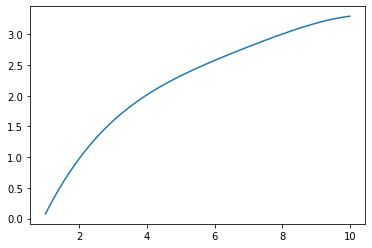

In [210]:
x1=np.arange(1,10.0,0.001)
m, exp= np.frexp(x1)
y2=np.log2(m*2**exp)
pred3=Chebyshev(m*2**exp,y2,ord)
plt.plot(m*2**exp,pred3)


<b>2.a)</b> Look at the file 229614158 PDCSAP SC6.txt (thanks to Matt Lundy).
We’ll model the flare as an exponential decay starting sharply
at some time. Is this model linear? What would your model look like, and what
are approximate starting guess values? Plot the data and your starting guess,
zoomed into the flare region (around t=1706)

(1706.5, 1707)

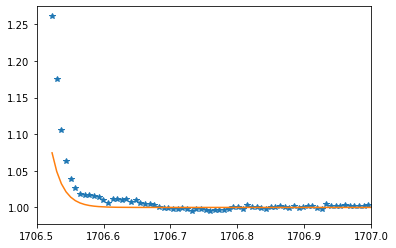

In [211]:
data=np.loadtxt('/Users/jmlascar/phys512/problem_sets/229614158_PDCSAP_SC6.txt',delimiter=',')
x,y=data[:,0],data[:,1]
t=[]
F=[]
n=0

for i in range(0,len(x)):
    if x[i] > 1706.52:
        t.append(x[i])
        F.append(y[i])
        n=n+1
T=np.zeros(np.shape(t))
T=T+1706.52

def gauss_derivs(pars,t):
    #p0 = f0 (amplitude)
    #p1 = c (offset)
    #p2 = k (rate)
    a = pars[0]#guessed three parameters
    c = pars[1]
    k = pars[2]
    model =np.exp(-k*(t-T)) #the exp we want to fit
    fun = a*model+c #this is the function value
    # the derivatives
    d0 = model #derivative with respect to parameters                      # w.r.t a
    d1 = 1.0                      # w.r.t c
    d2 = -model*a*(t-T)  # w.r.t k
    npar = 3
    derivs = np.zeros([len(t),npar])
    derivs[:,0]=d0
    derivs[:,1]=d1
    derivs[:,2]=d2
    return fun,derivs

a=0.09
c=1
k=60

guess = np.asarray([a,c,k])
pars = guess.copy()
fun,derivs = gauss_derivs(guess,t)
plt.clf();
plt.plot(t,F,"*")
plt.plot(t,fun)
axes = plt.gca() 
axes.set_xlim([1706.5,1707]) 

<b>b)</b> Keeping the flare starting time fixed (floating that is tricky given that the time is discretized), 
write a function using Newton’s method to fit flare parameters by minimizing χ2. 
If your starting guess is reasonable, you should not need to switch to Levenberg-Marquardt. 
What are your best-fit parameters? Add your best-fit model to your zoomed-in plot from part a).

change in chisq is 0.0
change in chisq is 0.05881082860248279
change in chisq is 0.055441955855831754
change in chisq is 0.05131291793458327
change in chisq is 0.042065710363470385
The best parameters are [  0.2767508    0.99983344 101.61140038]


(1706.5, 1707)

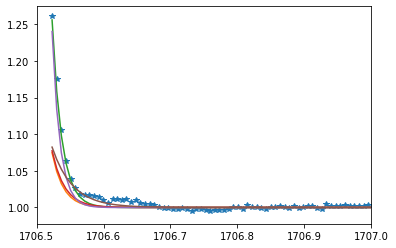

In [212]:
def newton(guess,t,F):
    pars = guess.copy()
    fun,derivs = gauss_derivs(guess,t)
    chi_old = np.sum((fun-F)**2)
    chi_thresh=0.01
    plt.plot(t,F,"*")
    for i in range(5):
        fun2,derivs = gauss_derivs(pars,t)
        resid = F-fun2 #d-A
        chi_new = np.sum(resid**2)
        grad = 2.*np.dot(derivs.transpose(),resid) #calculate the gradient 
        curve = 2.*np.dot(derivs.transpose(),derivs) #grad^2 
        pars = guess+np.dot(np.linalg.inv(curve),grad) #find the next root of chi^2
        print("change in chisq is "+repr(np.abs(chi_old-chi_new)))
        chi_old = chi_new
        plt.plot(t,fun2)  
    return fun2,pars

fun2,pars=newton(guess,t,F)
print("The best parameters are",pars)      
axes = plt.gca() 
axes.set_xlim([1706.5,1707]) 

c) What are your estimates for the errors on the fit parameters? 
Please explain how you modelled them, and comment on if you think they are reasonable. 



change in chisq is 0.0
change in chisq is 5.678944263631802e-05
change in chisq is 4.648160150615664e-05
change in chisq is 4.5447449135175774e-05
change in chisq is 3.79361934766077e-05
Estimates on error for the fit parameters are [1.83689321e-01 1.49944572e-04 6.89865268e+01]


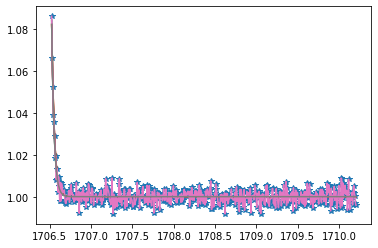

In [213]:
#We can use additive gaussian white noise:  

#RMS=np. sqrt(np. mean((y-M)**2))

noise = np.random.normal(0, np.sqrt(10e-6), len(t))
fun_noise=fun2+noise

guess_noise=np.asarray([0.09,1,30])
funtest,derivs = gauss_derivs(guess_noise,t)
new_fit,new_pars=newton(guess_noise,t,fun_noise)

error_para=np.abs(new_pars-pars)
print("Estimates on error for the fit parameters are",error_para)
#these were modelled by adding gaussian noise to our fit, 
#then refitting the function.

plt.plot(t,fun_noise)
plt.plot(t,fun2)
plt.show()

